# Course Recommendation System

## 1. IMPORT ALL NECESSARY LIBRARIES

In [69]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

## 2. LOAD DATASET

In [72]:
try:
    df = pd.read_csv("coursera_course_2024.csv")
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("ERROR: 'coursera_course_2024.csv' not found in directory")
    exit()
except Exception as e:
    print(f"ERROR loading file: {e}")
    exit()

print(f"First 5 rows preview:")
df.head()

Dataset loaded: 6645 rows, 14 columns
First 5 rows preview:


,Unnamed: 0,title,enrolled,rating,num_reviews,Instructor,Organization,Skills,Description,Modules/Courses,Level,Schedule,URL,Satisfaction Rate
0,0,Analytical Solutions to Common Healthcare Prob...,"5,710",4.6,27.0,Brian Paciotti,"University of California, Davis",[],"In this course, we’re going to go over analyti...",4 modules,Intermediate level,10 hours to complete (3 weeks at 3 hours a week),https://www.coursera.org/learn/analytical-solu...,NaN
1,1,Understanding Einstein: The Special Theory of ...,"170,608",4.9,3061.0,Larry Randles Lagerstrom,Stanford University,[],In this course we will seek to “understand Ein...,8 modules,Beginner level,NaN,https://www.coursera.org/learn/einstein-relati...,98%
2,2,JavaScript for Beginners Specialization,"37,762",4.7,772.0,William Mead,"University of California, Davis","['web interactivty', 'Jquery', 'Data Manipulat...",This Specialization is intended for the learne...,4 course series,Beginner level,2 months (at 10 hours a week),https://www.coursera.org/specializations/javas...,NaN
3,3,"Security, Compliance, and Governance for AI So...",Enrollment number not found,Rating not found,2024.0,AWS Instructor,Amazon Web Services,[],This course helps you understand some common i...,1 module,Beginner level,1 hour to complete,https://www.coursera.org/learn/security-compli...,NaN
4,4,Understanding Fitness Programming,Enrollment number not found,Rating not found,NaN,Casey DeJong,National Academy of Sports Medicine,"['Cardiovascular training', 'Resistance traini...","In this course, you will learn to identify app...",5 modules,Beginner level,27 hours to complete (3 weeks at 9 hours a week),https://www.coursera.org/learn/understanding-f...,NaN


## 3. DATA PREPROCESSING

### Step 1: Check initial data quality

In [75]:
print("\nStep 1: Checking data quality...")
print(f"Initial missing values per column:")
print(df.isnull().sum())
print(f"Total duplicates: {df.duplicated().sum()}")


Step 1: Checking data quality...
Initial missing values per column:
Unnamed: 0              0
title                   0
enrolled                0
rating                  0
num_reviews          1392
Instructor              1
Organization            0
Skills                  0
Description            10
Modules/Courses        10
Level                 778
Schedule             1888
URL                     0
Satisfaction Rate    4447
dtype: int64
Total duplicates: 0


### Step 2: Define specific column groups

In [77]:
#Text Columns List
text_cols = ['title', 'Skills', 'Description', 'Instructor', 'Organization', 'Modules/Courses', 'Level']
# Numeric Columns List
num_cols = ['rating', 'num_reviews', 'enrolled', 'Satisfaction Rate']

### Step 3: Handle text columns

In [79]:
df[text_cols] = df[text_cols].fillna("unknown")
print("Filled missing text with 'unknown'")

Filled missing text with 'unknown'


### Step 4: Handle numeric columns

In [81]:
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
print("Converted numeric columns and filled missing with 0")

Converted numeric columns and filled missing with 0


In [82]:
#Checking after handling the empty value for text and numeric column
df[text_cols].isnull().sum()

title              0
Skills             0
Description        0
Instructor         0
Organization       0
Modules/Courses    0
Level              0
dtype: int64

In [83]:
df[num_cols].isnull().sum()

rating               0
num_reviews          0
enrolled             0
Satisfaction Rate    0
dtype: int64

### Step 5: Remove duplicates

In [ ]:
initial_count = len(df)
df = df.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
final_count = len(df)
print(f"Removed {initial_count - final_count} duplicate courses")

### Step 6: Clean Skills column

In [87]:
df['Skills'] = df['Skills'].astype(str)
df['Skills'] = df['Skills'].str.replace(r"[\[\]']", "", regex=True)
df['Skills'] = df['Skills'].str.strip()
print("Cleaned Skills formatting")

Cleaned Skills formatting


### Step 7: Create combined text profile

In [89]:
df['text_profile'] = df[text_cols].agg(" ".join, axis=1)
print(f"Created text profiles (avg length: {df['text_profile'].str.len().mean():.0f} chars)")

Created text profiles (avg length: 3371 chars)


## 4. DATA ANALYSIS VISUALIZATIONS

### Set up figure with 8 subplots

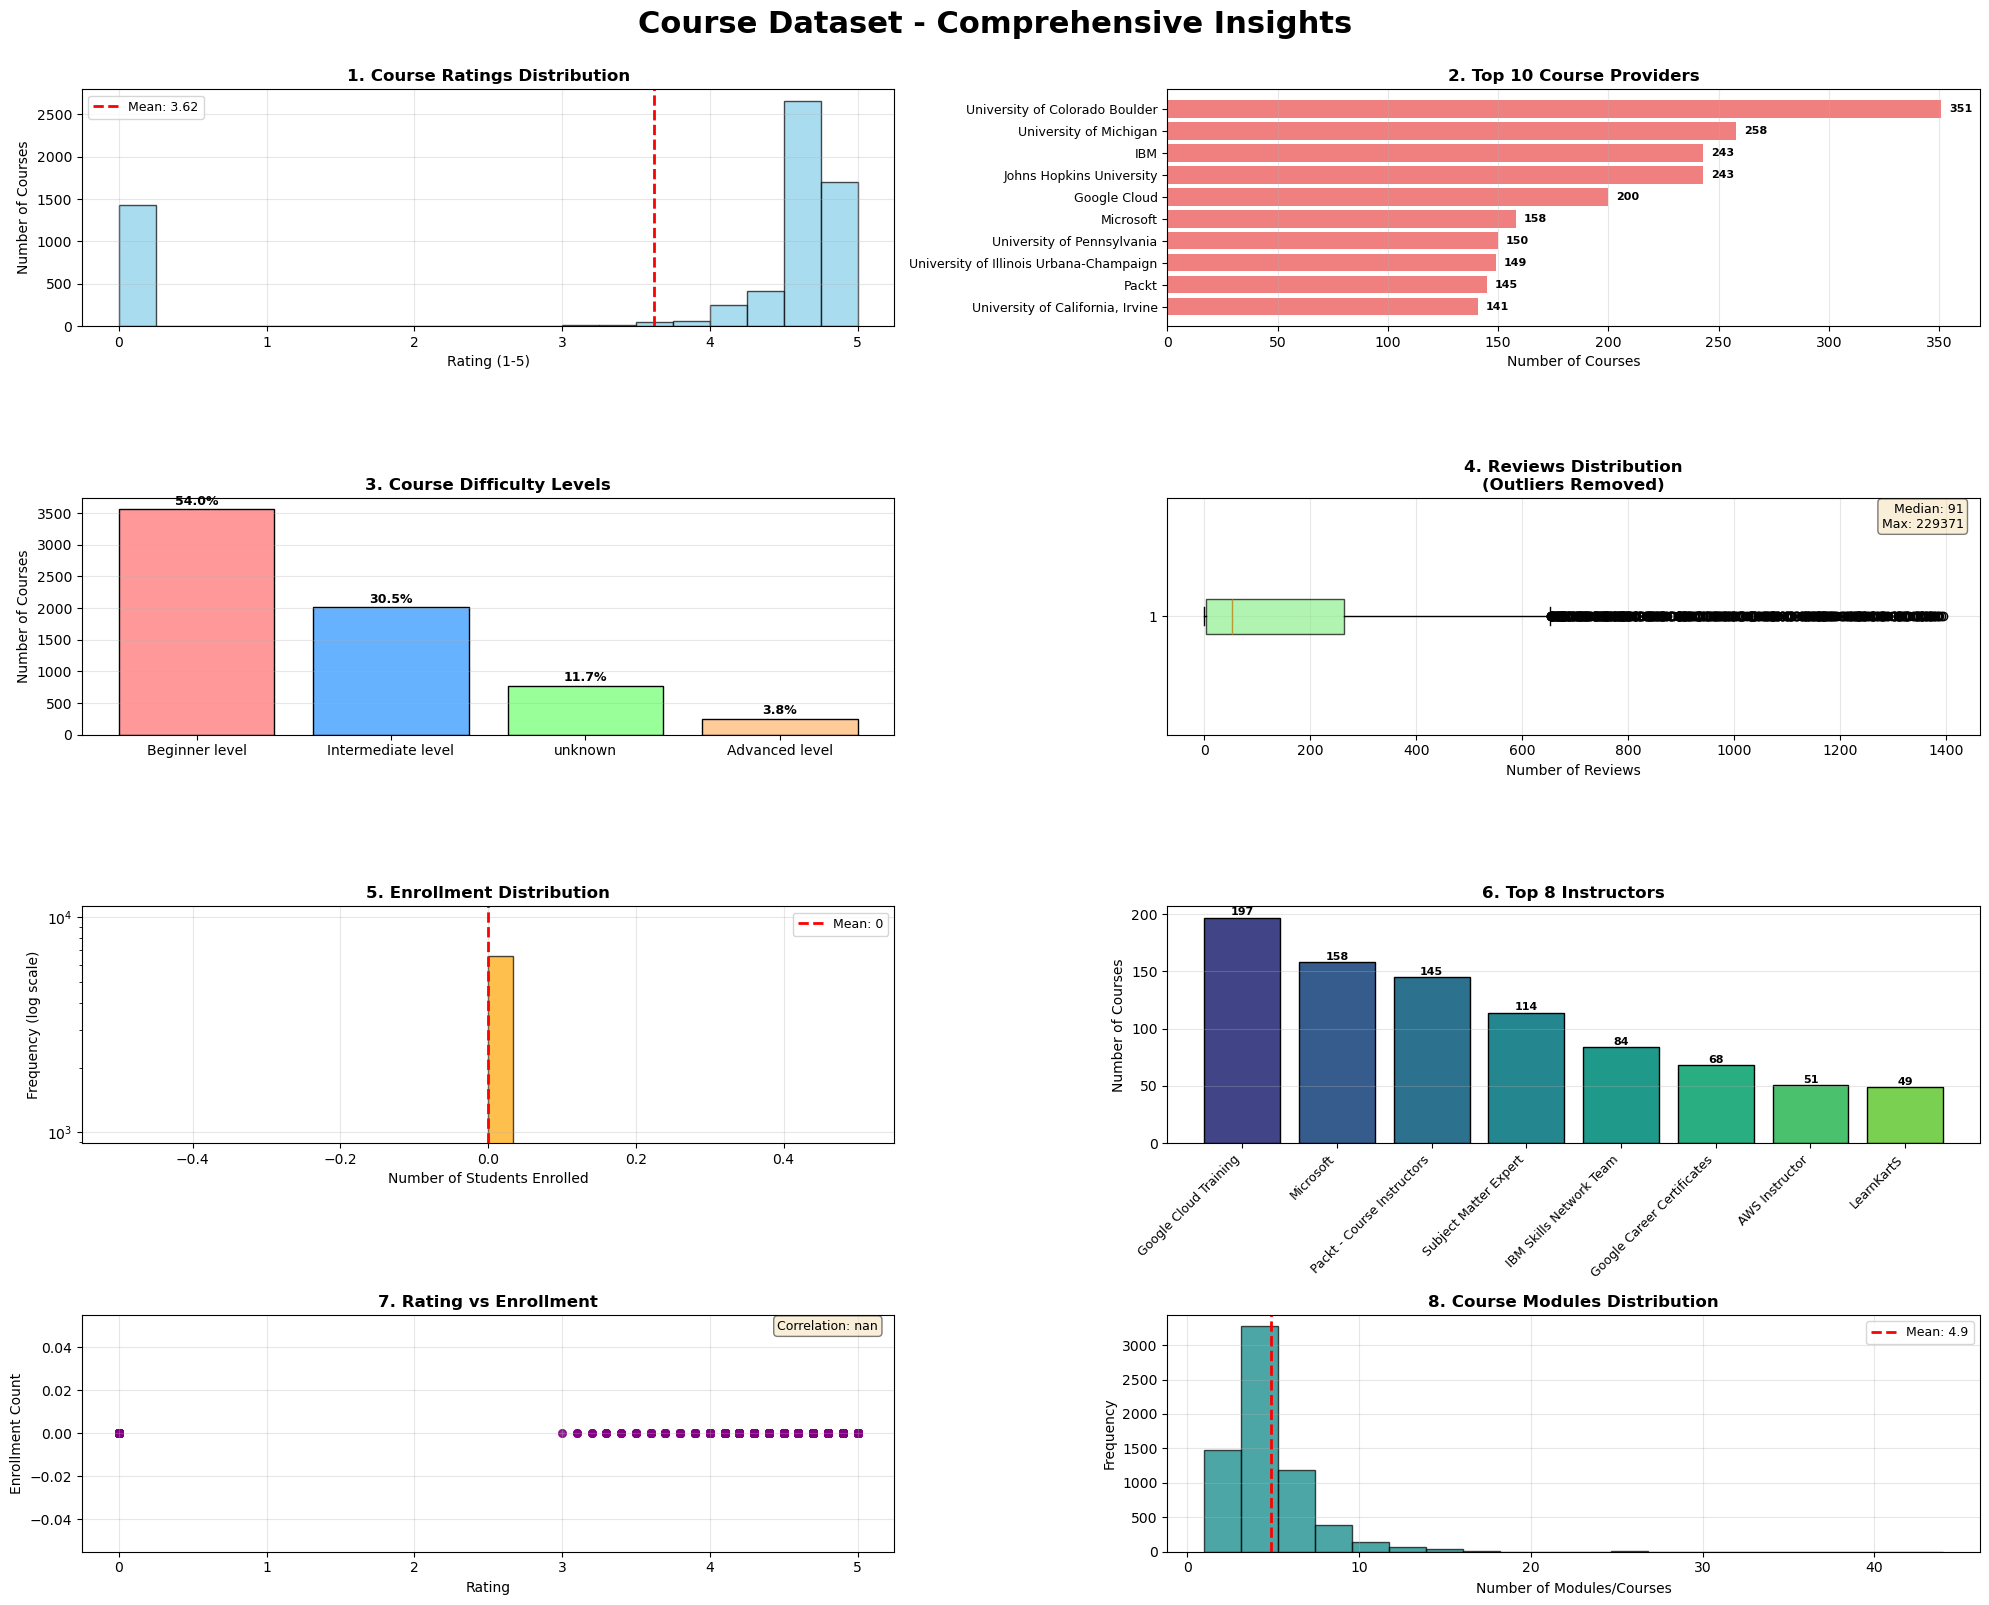

In [92]:
# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create a single figure with all 8 plots
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Course Dataset - Comprehensive Insights', fontsize=22, fontweight='bold', y=1.0)

# Create 4x2 grid layout
axes = []
for i in range(8):
    if i < 4:
        ax = fig.add_subplot(4, 2, i+1)
    else:
        ax = fig.add_subplot(4, 2, i+1)
    axes.append(ax)

# ========== PLOT 1: Course Ratings Distribution ==========
ax1 = axes[0]
if 'rating' in df.columns:
    rating_clean = pd.to_numeric(df['rating'], errors='coerce').dropna()
    ax1.hist(rating_clean, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(rating_clean.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {rating_clean.mean():.2f}')
    ax1.set_xlabel('Rating (1-5)')
    ax1.set_ylabel('Number of Courses')
    ax1.set_title('1. Course Ratings Distribution', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

# ========== PLOT 2: Top 10 Course Providers ==========
ax2 = axes[1]
if 'Organization' in df.columns:
    org_counts = df['Organization'].value_counts().head(10)
    bars = ax2.barh(range(len(org_counts)), org_counts.values, color='lightcoral')
    ax2.set_yticks(range(len(org_counts)))
    ax2.set_yticklabels(org_counts.index, fontsize=9)
    ax2.set_xlabel('Number of Courses')
    ax2.set_title('2. Top 10 Course Providers', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    
    for i, v in enumerate(org_counts.values):
        ax2.text(v + max(org_counts.values)*0.01, i, str(v), 
                va='center', fontsize=8, fontweight='bold')

# ========== PLOT 3: Course Difficulty Levels ==========
ax3 = axes[2]
if 'Level' in df.columns:
    level_counts = df['Level'].value_counts()
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    
    bars = ax3.bar(range(len(level_counts)), level_counts.values, 
                  color=colors[:len(level_counts)], edgecolor='black')
    ax3.set_xticks(range(len(level_counts)))
    ax3.set_xticklabels(level_counts.index, fontsize=10)
    ax3.set_ylabel('Number of Courses')
    ax3.set_title('3. Course Difficulty Levels', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    total = level_counts.sum()
    for i, v in enumerate(level_counts.values):
        percentage = (v / total) * 100
        ax3.text(i, v + max(level_counts.values)*0.02, f'{percentage:.1f}%', 
                ha='center', fontsize=9, fontweight='bold')

# ========== PLOT 4: Reviews Distribution ==========
ax4 = axes[3]
if 'num_reviews' in df.columns:
    reviews_clean = pd.to_numeric(df['num_reviews'], errors='coerce').dropna()
    
    q1, q3 = reviews_clean.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    filtered_reviews = reviews_clean[reviews_clean <= upper_bound]
    
    ax4.boxplot(filtered_reviews, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.7))
    ax4.set_xlabel('Number of Reviews')
    ax4.set_title('4. Reviews Distribution\n(Outliers Removed)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    stats_text = f"Median: {reviews_clean.median():.0f}\nMax: {reviews_clean.max():.0f}"
    ax4.text(0.98, 0.98, stats_text, transform=ax4.transAxes,
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ========== PLOT 5: Enrollment Distribution ==========
ax5 = axes[4]
if 'enrolled' in df.columns:
    def clean_enrollment(x):
        if isinstance(x, str):
            x = x.replace(',', '').replace('Enrollment number not found', 'nan')
        try:
            return float(x)
        except:
            return np.nan
    
    enrolled_clean = df['enrolled'].apply(clean_enrollment).dropna()
    
    if len(enrolled_clean) > 0:
        ax5.hist(enrolled_clean, bins=30, color='orange', edgecolor='black', alpha=0.7, log=True)
        ax5.axvline(enrolled_clean.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {enrolled_clean.mean():,.0f}')
        ax5.set_xlabel('Number of Students Enrolled')
        ax5.set_ylabel('Frequency (log scale)')
        ax5.set_title('5. Enrollment Distribution', fontsize=12, fontweight='bold')
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)

# ========== PLOT 6: Top 8 Instructors ==========
ax6 = axes[5]
if 'Instructor' in df.columns:
    instructor_counts = df['Instructor'].value_counts().head(8)
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(instructor_counts)))
    
    bars = ax6.bar(range(len(instructor_counts)), instructor_counts.values, 
                  color=colors, edgecolor='black')
    ax6.set_xticks(range(len(instructor_counts)))
    ax6.set_xticklabels(instructor_counts.index, rotation=45, ha='right', fontsize=9)
    ax6.set_ylabel('Number of Courses')
    ax6.set_title('6. Top 8 Instructors', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(instructor_counts.values):
        ax6.text(i, v + max(instructor_counts.values)*0.01, str(v), 
                ha='center', fontsize=8, fontweight='bold')

# ========== PLOT 7: Rating vs Enrollment ==========
ax7 = axes[6]
if all(col in df.columns for col in ['rating', 'enrolled']):
    rating_clean = pd.to_numeric(df['rating'], errors='coerce')
    enrolled_clean = df['enrolled'].apply(clean_enrollment)
    
    mask = rating_clean.notna() & enrolled_clean.notna()
    if mask.any():
        scatter = ax7.scatter(rating_clean[mask], enrolled_clean[mask], 
                             alpha=0.6, s=30, c='purple')
        ax7.set_xlabel('Rating')
        ax7.set_ylabel('Enrollment Count')
        ax7.set_title('7. Rating vs Enrollment', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3)
        
        correlation = np.corrcoef(rating_clean[mask], enrolled_clean[mask])[0, 1]
        ax7.text(0.98, 0.98, f'Correlation: {correlation:.2f}', 
                transform=ax7.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ========== PLOT 8: Modules Distribution ==========
ax8 = axes[7]
if 'Modules/Courses' in df.columns:
    modules_data = df['Modules/Courses'].dropna().astype(str)
    numeric_counts = []
    
    for item in modules_data:
        numbers = re.findall(r'\d+', item)
        if numbers:
            numeric_counts.append(int(numbers[0]))
    
    if numeric_counts:
        ax8.hist(numeric_counts, bins=20, color='teal', 
                edgecolor='black', alpha=0.7)
        ax8.axvline(np.mean(numeric_counts), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(numeric_counts):.1f}')
        ax8.set_xlabel('Number of Modules/Courses')
        ax8.set_ylabel('Frequency')
        ax8.set_title('8. Course Modules Distribution', fontsize=12, fontweight='bold')
        ax8.legend(fontsize=9)
        ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##  5. Natural Language PROCESSING FUNCTIONS

In [94]:
def clean_text(text):
    """
    Clean and normalize text for processing
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\\s]', ' ', text)
    text = re.sub(r'\\s+', ' ', text)
    return text.strip()

def tokenize_text(text):
    """
    Split text into individual words
    """
    return clean_text(text).split()

def avg_word2vec(words, model):
    """
    Convert list of words to average Word2Vec vector
    """
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

## 6. Recommendation Scoring Functions

In [96]:
def calculate_similarity_score(query, course_text, model_type, models_dict):
    """
    Calculate similarity score between query and course text
    """
    query_tokens = tokenize_text(query)
    
    if model_type == 'bow':
        # Bag-of-Words similarity
        query_vec = models_dict['bow']['vectorizer'].transform([query])
        course_vec = models_dict['bow']['vectorizer'].transform([course_text])
        return cosine_similarity(query_vec, course_vec)[0][0]
    
    elif model_type == 'tfidf':
        # TF-IDF similarity
        query_vec = models_dict['tfidf']['vectorizer'].transform([query])
        course_vec = models_dict['tfidf']['vectorizer'].transform([course_text])
        return cosine_similarity(query_vec, course_vec)[0][0]
    
    elif model_type == 'w2v':
        # Word2Vec similarity
        query_vec = avg_word2vec(query_tokens, models_dict['w2v']['model']).reshape(1, -1)
        course_tokens = tokenize_text(course_text)
        course_vec = avg_word2vec(course_tokens, models_dict['w2v']['model']).reshape(1, -1)
        return cosine_similarity(query_vec, course_vec)[0][0]
    
    return 0

def calculate_content_match(query, course_text):
    """
    Calculate content match percentage (0-100%)
    """
    query_words = set(tokenize_text(query))
    course_words = set(tokenize_text(course_text))
    
    if not query_words:
        return 0
    
    common_words = query_words.intersection(course_words)
    match_percent = (len(common_words) / len(query_words)) * 100
    return round(match_percent, 1)

def calculate_skill_match(query, course_skills):
    """
    Calculate skill match score (0-1)
    """
    query_words = [w for w in tokenize_text(query) if len(w) > 2]
    skills_text = course_skills.lower()
    
    if not query_words:
        return 0
    
    matches = 0
    for word in query_words:
        if word in skills_text:
            matches += 1
    
    return round(matches / len(query_words), 2)

def calculate_popularity_score(rating, reviews, max_reviews):
    """
    Calculate popularity score (0-1)
    """
    # Rating component (0-1)
    rating_score = rating / 5.0
    
    # Reviews component (normalized)
    if max_reviews > 0:
        reviews_score = min(reviews / max_reviews, 1)
    else:
        reviews_score = 0
    
    # Combined score (70% rating, 30% reviews)
    popularity_score = (0.7 * rating_score) + (0.3 * reviews_score)
    return round(popularity_score, 2)

## 7. MODEL TRAINING

In [98]:
# Prepare training data
tokenized_texts = df['text_profile'].apply(tokenize_text).tolist()

# Initialize models dictionary
models = {}

# Train Bag-of-Words model
print("Training Bag-of-Words model...")
bow_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
bow_matrix = bow_vectorizer.fit_transform(df['text_profile'])
models['bow'] = {'vectorizer': bow_vectorizer, 'matrix': bow_matrix}
print("Bag-of-Words trained")

# Train TF-IDF model
print("Training TF-IDF model...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_profile'])
models['tfidf'] = {'vectorizer': tfidf_vectorizer, 'matrix': tfidf_matrix}
print("TF-IDF trained")

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    epochs=10
)

# Create Word2Vec document vectors
w2v_vectors = []
for text in df['text_profile']:
    tokens = tokenize_text(text)
    vector = avg_word2vec(tokens, w2v_model)
    w2v_vectors.append(vector)

w2v_matrix = np.array(w2v_vectors)
models['w2v'] = {'model': w2v_model, 'matrix': w2v_matrix}
print("Word2Vec trained")

# Get max reviews for popularity normalization
max_reviews = df['num_reviews'].max()

Training Bag-of-Words model...
Bag-of-Words trained
Training TF-IDF model...
TF-IDF trained
Training Word2Vec model...
Word2Vec trained


## 8. Multi-Model Recommendation Engine

In [100]:
def calculate_precision(query, recommendations, top_k=5):
    """
    Calculate precision@k based on keyword matching
    """
    query_terms = set(tokenize_text(query))
    
    relevant_count = 0
    for idx in recommendations[:top_k]:
        course_text = df.loc[idx, 'text_profile']
        course_terms = set(tokenize_text(course_text))
        
        if query_terms & course_terms:
            relevant_count += 1
    
    return relevant_count / top_k
    
def recommend_courses_with_scores(query, top_k=5):
    """
    Generate recommendations using all three models WITH SCORES
    """
    results = {}
    
    # Process query for each model
    query_tokens = tokenize_text(query)
    
    # Get similarity scores from each model
    similarity_scores = {
        "Bag-of-Words": cosine_similarity(
            models['bow']['vectorizer'].transform([query]),
            models['bow']['matrix']
        ).flatten(),
        
        "TF-IDF": cosine_similarity(
            models['tfidf']['vectorizer'].transform([query]),
            models['tfidf']['matrix']
        ).flatten(),
        
        "Word2Vec": cosine_similarity(
            avg_word2vec(query_tokens, models['w2v']['model']).reshape(1, -1),
            models['w2v']['matrix']
        ).flatten(),
    }
    
    for model_name, scores in similarity_scores.items():
        # Get top indices
        top_indices = scores.argsort()[-top_k:][::-1]
        
        # Prepare results list for this model
        recommendations_list = []
        
        # Get details for each recommended course
        for rank, idx in enumerate(top_indices, 1):
            course = df.iloc[idx]
            
            # Calculate all 4 scores for this course
            model_type = 'bow' if model_name == 'Bag-of-Words' else \
                        'tfidf' if model_name == 'TF-IDF' else 'w2v'
            
            similarity = round(scores[idx], 3)
            content_match = calculate_content_match(query, course['text_profile'])
            skill_match = calculate_skill_match(query, course['Skills'])
            popularity = calculate_popularity_score(
                course['rating'], 
                course['num_reviews'], 
                max_reviews
            )
            
            # Create course dict with scores
            course_dict = {
                'Rank': rank,
                'Course Title': course['title'],
                'Instructor': course['Instructor'],
                'Organization': course['Organization'],
                'Rating': course['rating'],
                'Reviews': int(course['num_reviews']),
                
                # 4 SCORES TO SHOW:
                'Similarity Score': similarity,          # Score 1
                'Content Match %': content_match,        # Score 2
                'Skill Match': skill_match,              # Score 3
                'Popularity Score': popularity,          # Score 4
            }
            
            recommendations_list.append(course_dict)
        
        # Calculate precision for this model
        precision = calculate_precision(query, top_indices, top_k)
        
        # Store results
        results[model_name] = {
            'recommendations': pd.DataFrame(recommendations_list),
            'precision': precision,
            'scores': scores
        }
    
    return results

## 9. USER INPUT VALIDATION

In [102]:
def get_user_query():
    """
    Get and validate user search query
    """
    while True:
        print("\n" + "=" * 50)
        query = input("Enter course topic or skill (e.g., 'Java', 'Data Science'): ").strip()
        
        # Check if empty
        if not query:
            print("Please enter a search term")
            continue
        
        # Check minimum length
        if len(query) < 2:
            print("Search term must be at least 2 characters")
            continue
        
        # Check if contains only letters and spaces
        if not re.match(r'^[a-zA-Z\s]+$', query):
            print("Only letters and spaces allowed")
            continue
        
        return query

## 10. Main Program

In [ ]:
while True:
    # Get valid query
    search_query = get_user_query()
    
    # Generate recommendations with scores
    print(f"\nSearching for: '{search_query}'")
    print("Processing recommendations with scores...")
    
    results = recommend_courses_with_scores(search_query, top_k=5)
    
    # Display results with scores
    for model_name, data in results.items():
        print(f"\n{'='*80}")
        print(f"{model_name.upper()} MODEL")
        print(f"{'='*80}")
        
        precision = data['precision']
        
        if precision < 0.2:
            print(f"Low relevance found (Precision: {precision:.2f})")
            print("Try different search terms")
        else:
            print(f"Top 5 Recommendations (Precision: {precision:.2f})")
            print("-" * 80)
            
            # Display each recommendation with all 4 scores
            for _, row in data['recommendations'].iterrows():
                print(f"\n#{row['Rank']}: {row['Course Title']}")
                print(f"   Instructor: {row['Instructor']} | Provider: {row['Organization']}")
                print(f"   Rating: {row['Rating']}/5.0 | Reviews: {row['Reviews']:,}")
                
                # Display the 4 scores clearly
                print("   SCORES:")
                print(f"     • Similarity: {row['Similarity Score']:.3f}")
                print(f"     • Content Match: {row['Content Match %']}%")
                print(f"     • Skill Match: {row['Skill Match']:.2f}")
                print(f"     • Popularity: {row['Popularity Score']:.2f}")
                
                # Visual score bars
                print("     • Score Bars:")
                print(f"        Similarity: {'█' * int(row['Similarity Score'] * 10)} ({row['Similarity Score']:.3f})")
                print(f"        Content: {'█' * int(row['Content Match %'] / 10)} ({row['Content Match %']}%)")

    
    # Ask to continue
    print("\n" + "=" * 80)
    continue_search = input("\nSearch again? (y/n): ").strip().lower()
    
    if continue_search != 'y':
        print("\n" + "=" * 80)
        print("Thank you for using the Course Recommendation System!")
        print("=" * 80)
        break


Enter course topic or skill (e.g., 'Java', 'Data Science'):  Science



Searching for: 'Science'
Processing recommendations with scores...

BAG-OF-WORDS MODEL
Top 5 Recommendations (Precision: 1.00)
--------------------------------------------------------------------------------

#1: Rocket Science in Everyday Life
   Instructor: Aaron Ridley | Provider: University of Michigan
   Rating: 0.0/5.0 | Reviews: 0
   SCORES:
     • Similarity: 0.660
     • Content Match: 100.0%
     • Skill Match: 1.00
     • Popularity: 0.00
     • Score Bars:
        Similarity: ██████ (0.660)
        Content: ██████████ (100.0%)

#2: Data Science as a Field
   Instructor: Jane Wall | Provider: University of Colorado Boulder
   Rating: 4.3/5.0 | Reviews: 34
   SCORES:
     • Similarity: 0.645
     • Content Match: 100.0%
     • Skill Match: 1.00
     • Popularity: 0.60
     • Score Bars:
        Similarity: ██████ (0.645)
        Content: ██████████ (100.0%)

#3: Designing Effective Science Communication
   Instructor: Melanie Peffer | Provider: University of Colorado Boulder


Search again? (y/n):  y


Enter course topic or skill (e.g., 'Java', 'Data Science'):  Java



Searching for: 'Java'
Processing recommendations with scores...

BAG-OF-WORDS MODEL
Top 5 Recommendations (Precision: 1.00)
--------------------------------------------------------------------------------

#1: Introduction to Java
   Instructor: Noel J. Bergman | Provider: LearnQuest
   Rating: 4.6/5.0 | Reviews: 1,923
   SCORES:
     • Similarity: 0.789
     • Content Match: 100.0%
     • Skill Match: 1.00
     • Popularity: 0.65
     • Score Bars:
        Similarity: ███████ (0.789)
        Content: ██████████ (100.0%)

#2: Java Class Library
   Instructor: Evan Bergman | Provider: LearnQuest
   Rating: 4.7/5.0 | Reviews: 155
   SCORES:
     • Similarity: 0.774
     • Content Match: 100.0%
     • Skill Match: 0.00
     • Popularity: 0.66
     • Score Bars:
        Similarity: ███████ (0.774)
        Content: ██████████ (100.0%)

#3: Core Java Specialization
   Instructor: Evan Bergman | Provider: LearnQuest
   Rating: 4.6/5.0 | Reviews: 1,589
   SCORES:
     • Similarity: 0.757
    